In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mirae = pd.read_csv('/content/drive/MyDrive/미래에셋/mirae_stockname.csv')

### 1. 수익률 계산

In [ ]:
#매달 '국내 주식 매도'와 '국내 주식 매수' 칼럼을 모아놓음
maesu_col = []
maedo_col = []
for x in list(mirae.columns):
  if '국내주식매수' in x:
    maesu_col.append(x)
  elif '국내주식매도' in x:
    maedo_col.append(x)

In [ ]:
mirae['총매수금액'] = mirae['국내주식자산_202006']
mirae['총매도금액'] = mirae['국내주식자산_202105']

#총 매수금액, 총 매도금액을 계산
for i in maesu_col[:-1]:
  mirae['총매수금액'] = mirae['총매수금액'] + mirae[i]
for i in maedo_col[1:]:
  mirae['총매도금액'] = mirae['총매도금액'] + mirae[i]

#수익률 계산
mirae['수익률'] = (mirae['총매도금액'] - mirae['총매수금액']) / mirae['총매수금액']

#수익률이 너무 크게 계산되거나(수익률 50% 이상) 수익률이 너무 작게 계산되면 제외(수익률 -50% 이하)
def overone(x):
  if float(x) >= 0.5 or float(x) <= -0.5:
    return None
  return float(x) * 100
mirae['수익률'] = mirae['수익률'].apply(overone)

del mirae['총매도금액']
del mirae['총매수금액']

### 2. 선호 주식 보유 기간과 수익률의 상관관계

In [ ]:
#선호 주식 보유 기간 정보 불러오기
df_jangdan = pd.read_csv('/content/drive/MyDrive/미래에셋/전처리/data/jangdan_cluster.csv')

In [ ]:
#앞의 수익률 칼럼과 선호 주식 보유 기간 정보를 merge함
mirae_jangdan = pd.merge(mirae[['수익률']], df_jangdan[['jangdan_cluster']], left_index = True, right_index = True, how = 'left')[['수익률','jangdan_cluster']]
mirae_jangdan.dropna(inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



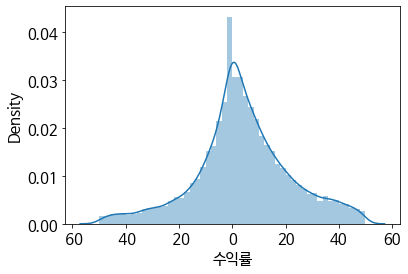

In [ ]:
#한글 폰트 불러오기
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 15})
plt.rc('font', family='NanumBarunGothic')
#cluster1(장기 보유 선호) 수익률 그래프
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 1]['수익률'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



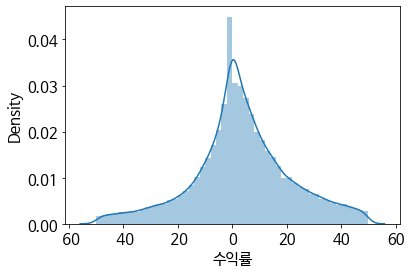

In [ ]:
#cluster2(단기 보유 선호) 수익률 그래프
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 2]['수익률'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

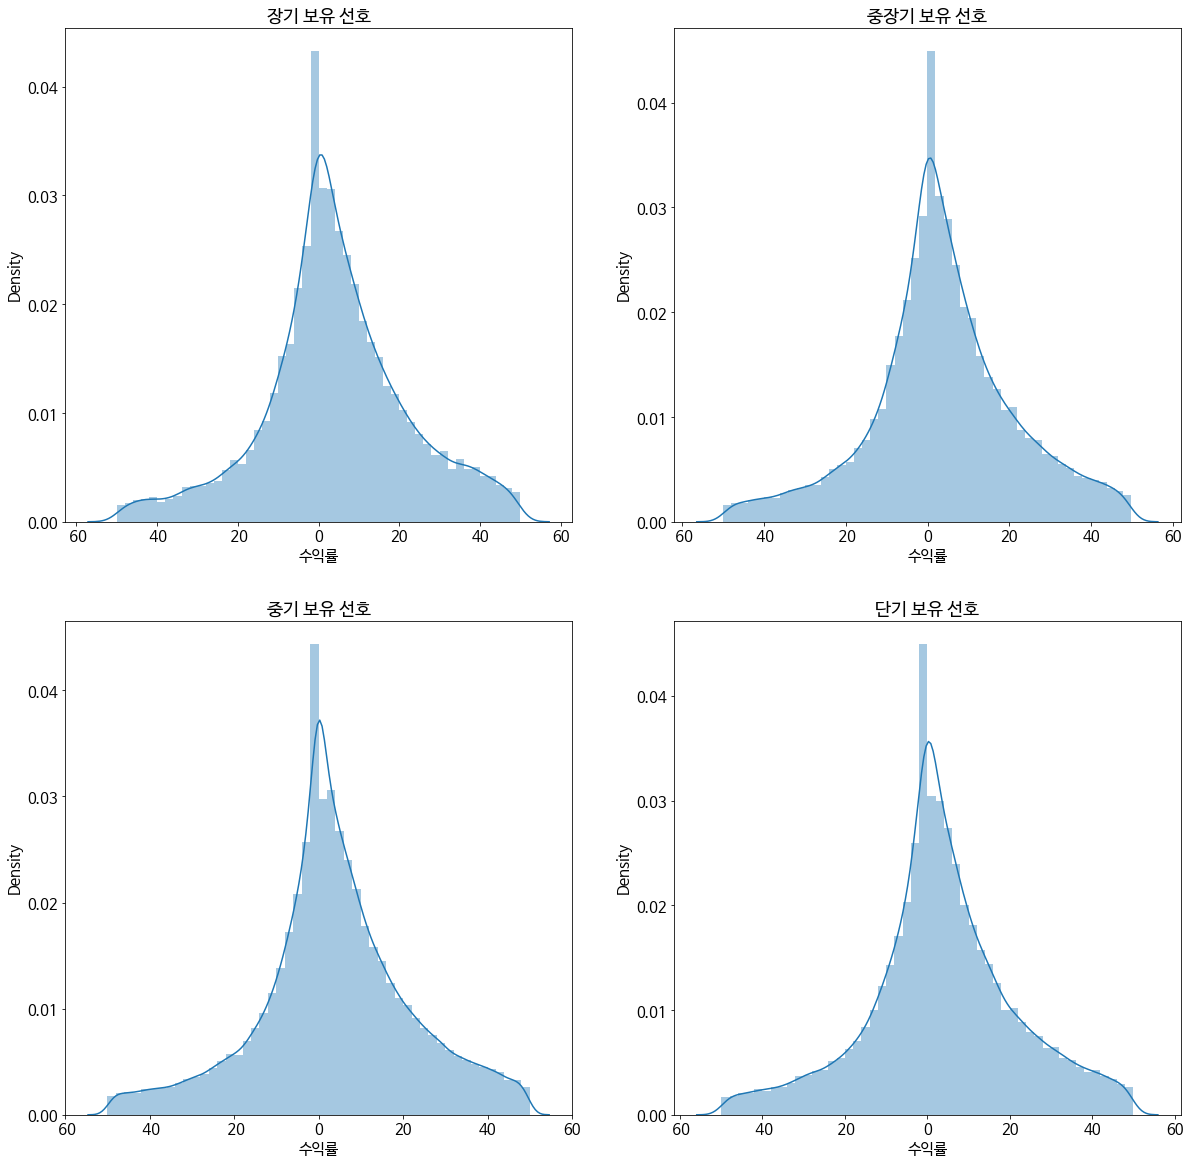

In [ ]:
#종합적으로 그래프 그리기
fig = plt.figure(figsize = (20,20))
area1 = fig.add_subplot(2,2,1)
area1.set_title('장기 보유 선호')
area2 = fig.add_subplot(2,2,2)
area2.set_title('중장기 보유 선호')
area3 = fig.add_subplot(2,2,3)
area3.set_title('중기 보유 선호')
area4 = fig.add_subplot(2,2,4)
area4.set_title('단기 보유 선호')

sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 1]['수익률'], ax = area1); #선호 보유 기간 : 장기
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 3]['수익률'], ax = area2); #선호 보유 기간 : 중장기
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 0]['수익률'], ax = area3); #선호 보유 기간 : 중기
sns.distplot(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 2]['수익률'], ax = area4); #선호 보유 기간 : 단기

In [ ]:
#여전히 그래프로도 뚜렷한 차이가 보이지 않지만, 평균을 구해보면 차이가 존재함을 알 수 있다.
print(mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 1]['수익률'].mean(), #
      mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 3]['수익률'].mean(),
      mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 0]['수익률'].mean(),
      mirae_jangdan[mirae_jangdan['jangdan_cluster'] == 2]['수익률'].mean())
#선호 주식 보유 기간이 장기, 중장기, 중기, 단기 수익률로, 장기 수익률이 가장 큰 것으로 볼 수 있다.

4.0063839841085525 3.5842205945894396 3.619130288346842 3.36985208370457


- 이를 통해 안정적이고 지속 가능성이 뚜렷한 기업을 추천해줘 장기 보유를 유도한다면 안정적인 수익을 얻을 수 있을 것이라 생각했으며, 이와 관련된 서비스를 만들어볼 예정